In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.data import Data
import numpy as np
import xarray as xr
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime
import os
import sys
from pathlib import Path
import calendar
import h5py as h5
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool

In [2]:
def list_months_between(start_date:str, end_date:str):
    
    d1 =  datetime.strptime(start_date,'%Y%m%d')
    d2 =  datetime.strptime(end_date,'%Y%m%d')
    # List to store the year-month pairs
    months = []
    # Initialize the current date to the start date
    current_date = d1

    while current_date <= d2:
        # Append the current year and month to the list
        months.append((current_date.year, current_date.month))
       
        # Move to the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return months

In [3]:
def load_rain_data(rain_data_dir:str,start_date:str,end_date:str):

    days_leap = [31,29,31,30,31,30,31,31,30,31,30,31]
    days_noleap = [31,28,31,30,31,30,31,31,30,31,30,31]
    
    months = list_months_between(start_date, end_date)
    index = 0
    path = Path(rain_data_dir)
    rain_final = np.zeros((0,351,401),dtype=np.float32)
    days = 0
    for mnth in months:
        fl = os.path.join(rain_data_dir,str.format('GRAIN_%d%.2d.mat'%(mnth[0],mnth[1])))
        print(fl)
        if calendar.isleap(mnth[0]) == True:
            d1 =  datetime.strptime(str.format('%d%d%d'%(mnth[0],mnth[1],days_leap[mnth[1]-1])),'%Y%m%d')
        else :
            d1 =  datetime.strptime(str.format('%d%d%d'%(mnth[0],mnth[1],days_noleap[mnth[1]-1])),'%Y%m%d')
            
        days = days + d1.day
        
        f = h5.File(fl, "r")

        if index==0:
            glat = f.get("glat")[()]
            glon = f.get("glon")[()]

        rain = f.get("GRAIN")[()]
        #rain = rain[0:672,:,:]

        print(rain.max(),rain.min())
        rain_final = np.concatenate((rain_final,rain),axis=0)

        f.close()
    
    #rain_final = rain_final.reshape((days,24,351,401)).astype(np.float32)
    print(f'days:{days}',rain_final.dtype) 
    return rain_final,glat,glon

In [4]:
# Normalize the data
def normalize(rain_final):
    scaler = MinMaxScaler()
    rain_final = scaler.fit_transform(rain_final.reshape(-1, rain_final.shape[-1])).reshape(rain_final.shape)

    return scaler,rain_final

In [5]:
def log_scale(data, epsilon=1e-6):
    """
    Apply log scaling to the data.
   
    :param data: Input data
    :param epsilon: Small value to avoid log(0)
    :return: Log-scaled data
    """
    return np.log(data + epsilon)

def inverse_log_scale(data, epsilon=1e-6):
    """
    Inverse of log scaling.
   
    :param data: Log-scaled data
    :param epsilon: Small value used in log scaling
    :return: Original scale data
    """
    return np.exp(data) - epsilon

In [6]:
dataset,glat,glon = load_rain_data('/home/intern/RAIN_DATA/RAJU_MAT','20220801','20220831')
print(dataset.shape,dataset.mean(),dataset.std())
dataset    = log_scale(dataset)

dataset = dataset[:50,:,:]
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]


print('train_dataset:',train_dataset.shape)
print('val_datset:',val_dataset.shape)

/home/intern/RAIN_DATA/RAJU_MAT/GRAIN_202208.mat
173.21914672851562 0.0
days:31 float64
(744, 351, 401) 0.2939812865997616 1.1543126980248
train_dataset: (45, 351, 401)
val_datset: (5, 351, 401)


In [7]:
def create_target_images(rain_data,prediction_offset=1):
    input_images = rain_data[:-prediction_offset]
    target_images = rain_data[prediction_offset:]
    return input_images,target_images

# Apply the processing function to the datasets.
x_train, y_train = create_target_images(train_dataset)
x_val, y_val = create_target_images(val_dataset)

print('x_train',x_train.shape,'y_train',y_train.shape)
print('x_val',x_val.shape,'y_val',y_val.shape)


x_train (44, 351, 401) y_train (44, 351, 401)
x_val (4, 351, 401) y_val (4, 351, 401)


In [8]:
def image_to_graph(image, target=None):
    # Flatten the image
    nodes = image.reshape(-1, 1)
   
    # Create edges
    height, width = image.shape
    edge_index = []
    for i in range(height):
        for j in range(width):
            if i > 0:
                edge_index.append([i*width + j, (i-1)*width + j])
            if i < height - 1:
                edge_index.append([i*width + j, (i+1)*width + j])
            if j > 0:
                edge_index.append([i*width + j, i*width + (j-1)])
            if j < width - 1:
                edge_index.append([i*width + j, i*width + (j+1)])
   
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
   
    # If we have a target (for supervised learning), include it
    if target is not None:
        target = torch.FloatTensor(target.reshape(-1, 1))
        return Data(x=torch.FloatTensor(nodes), edge_index=edge_index, y=target)
    else:
        return Data(x=torch.FloatTensor(nodes), edge_index=edge_index)

In [10]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')

# Create graph_data_list
graph_data_list = []

# Assuming you have a list of rain images and corresponding targets
for image, target in zip(x_train, y_train):
    graph_data = image_to_graph(image, target)
    graph_data_list.append(graph_data)




In [22]:
class RainPredictionGCN(nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(RainPredictionGCN, self).__init__()
        self.gcn1 = GCNConv(num_node_features, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.gcn3 = GCNConv(hidden_channels, hidden_channels)
        self.gcn4 = GCNConv(hidden_channels, 1)  # Output 1 value per node

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))
        x = self.gcn4(x, edge_index)
        return x




# Usage
input_channels = 1  # or more if you have multiple input features per pixel
num_node_features = 1  # Experiment with this value
hidden_channels = 16
batch_size = 8
num_epochs = 1


loader = DataLoader(graph_data_list,batch_size=batch_size,shuffle=False)
model = RainPredictionGCN(num_node_features, hidden_channels)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 25
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
   
    avg_loss = total_loss / len(graph_data_list)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
    

Epoch 1/25, Average Loss: 62.9925
Epoch 2/25, Average Loss: 42.0284
Epoch 3/25, Average Loss: 36.3690
Epoch 4/25, Average Loss: 34.7647
Epoch 5/25, Average Loss: 34.0152
Epoch 6/25, Average Loss: 33.3580
Epoch 7/25, Average Loss: 32.9456
Epoch 8/25, Average Loss: 32.4626
Epoch 9/25, Average Loss: 32.2788
Epoch 10/25, Average Loss: 32.2190
Epoch 11/25, Average Loss: 32.1994
Epoch 12/25, Average Loss: 32.1573
Epoch 13/25, Average Loss: 32.1557
Epoch 14/25, Average Loss: 32.1671
Epoch 15/25, Average Loss: 32.1480
Epoch 16/25, Average Loss: 32.1398
Epoch 17/25, Average Loss: 32.1429
Epoch 18/25, Average Loss: 32.1356
Epoch 19/25, Average Loss: 32.1297
Epoch 20/25, Average Loss: 32.1281
Epoch 21/25, Average Loss: 32.1239
Epoch 22/25, Average Loss: 32.1203
Epoch 23/25, Average Loss: 32.1176
Epoch 24/25, Average Loss: 32.1139
Epoch 25/25, Average Loss: 32.1112


In [18]:
def predict_rain(model, input_image, device):
    """
    Predict rain intensity using the trained GCN model.
   
    :param model: Trained RainPredictionGCN model
    :param input_image: 2D numpy array of shape (height, width) representing the input rain image
    :param device: torch.device object (cuda or cpu)
    :return: 2D numpy array of predicted rain intensity
    """
    model.eval()  # Set the model to evaluation mode
   
    # Convert input image to graph
    height, width = input_image.shape
    x = torch.FloatTensor(input_image.reshape(-1, 1)).to(device)
   
    # Create edges (connecting each pixel to its neighbors)
    edge_index = []
    for i in range(height):
        for j in range(width):
            node = i * width + j
            if i > 0:
                edge_index.append([node, (i-1) * width + j])
            if i < height - 1:
                edge_index.append([node, (i+1) * width + j])
            if j > 0:
                edge_index.append([node, i * width + (j-1)])
            if j < width - 1:
                edge_index.append([node, i * width + (j+1)])
   
    edge_index = torch.LongTensor(edge_index).t().contiguous().to(device)
   
    # Forward pass
    with torch.no_grad():
        out = model(x, edge_index)
   
    # Reshape output to match input image dimensions
    predicted_image = out.cpu().numpy().reshape(height, width)
   
    return predicted_image

Predicted rain image shape: (351, 401)
Min predicted value: -12.11192
Max predicted value: -4.215345


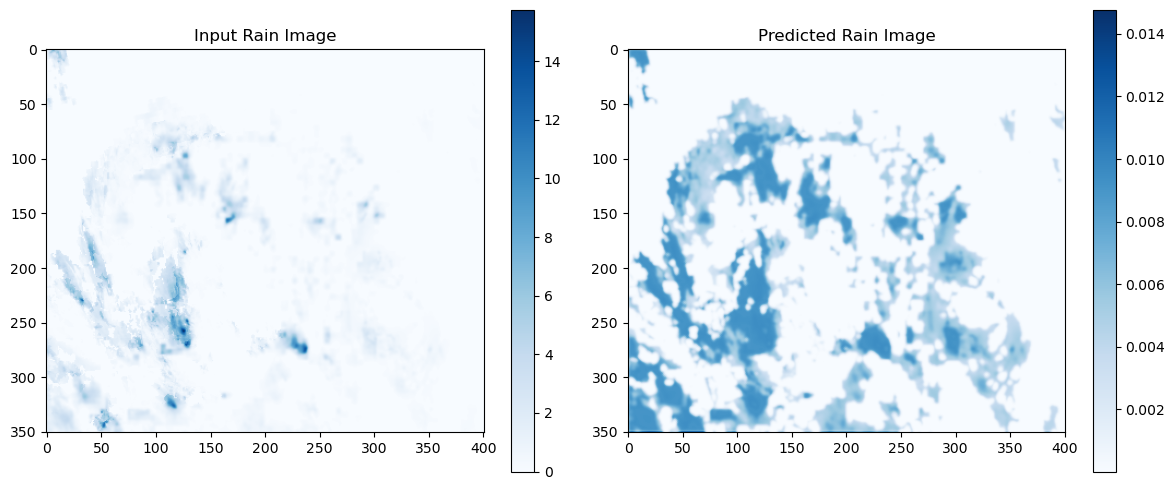

In [19]:

input_image = x_val[3]
# Make prediction
predicted_rain = predict_rain(model, input_image, device)

print("Predicted rain image shape:", predicted_rain.shape)
print("Min predicted value:", predicted_rain.min())
print("Max predicted value:", predicted_rain.max())

# Optionally, visualize the results
import matplotlib.pyplot as plt
input_image = inverse_log_scale(input_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax1.imshow(input_image, cmap='Blues')
ax1.set_title('Input Rain Image')
fig.colorbar(im1, ax=ax1)

#predicted_rain[predict_rain == predicted_rain.min()] = 0
predicted_rain = inverse_log_scale(predicted_rain)
im2 = ax2.imshow(predicted_rain, cmap='Blues')
ax2.set_title('Predicted Rain Image')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

In [42]:
torch.cuda.empty_cache()